In [133]:
from astroquery.gaia import Gaia
import pandas as pd

import time

# Query for all Ra/Dec sources in the box defined by the LLCC image 
# with distances <100pc (i.e. 10mas parallax)
query=' '.join([
                'SELECT *',
                'FROM gaiadr2.gaia_source',
                'WHERE 1=CONTAINS(POINT(\'ICRS\', ra, dec),BOX(\'ICRS\', 149, 10, 16,16))',
                'AND parallax >= 10'
                ])

# Launch the job with the given query and time the response
start=time.time()
job=Gaia.launch_job_async(query)
print '\n{:5.2f} s'.format(time.time()-start)

# Store results as table and convert to a Pandas dataframe
results=job.get_results()
results=results.to_pandas()

# Force id columns to int datatypes since default is float64 (which gets represented as scientific notation)
results[['source_id','solution_id']]=results[['source_id','solution_id']].astype(int)

print '{:} sources'.format(len(results))

Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE 1=CONTAINS(POINT('ICRS', ra, dec),BOX('ICRS', 149, 10, 16,16))'
Retrieving async. results...
Query finished.

1624.56 s
820302 sources


In [136]:
# Processing stuff:
# Process the image and define contours
# Define pixel coordinate columns to results

import numpy as np
from math import floor

from imageio import imread
import matplotlib.cbook as cbook
from skimage import measure

# Read image and convert to grayscale
datafile = cbook.get_sample_data('/Users/codydirks/PGCC/notebooks/llcc.png')
img = 255-np.dot(imread(datafile)[...,:3], [0.299, 0.587, 0.114])

# Get image dimension - used later to transform between pixel space and Ra/Dec
imgy,imgx=img.shape

# Find and plot contours given above threshold parameter
# 0-255 scale, higher == more lenient, lower == stricter
contour_thres=220
contours = measure.find_contours(img, contour_thres)

# Pick out larger contours, throw out miniscule fluctuations
filtered_contours = [c for c in contours if len(c)>100]

# Finds pixel coordinates of each sources Ra/Dec values
results['x']=pd.Series((results['ra']-157)*(-float(imgx)/16.)).apply(floor).astype(int)
results['y']=pd.Series((results['dec']-18)*(-float(imgy)/16.)).apply(floor).astype(int)

Text(0,0.5,u'Declination')

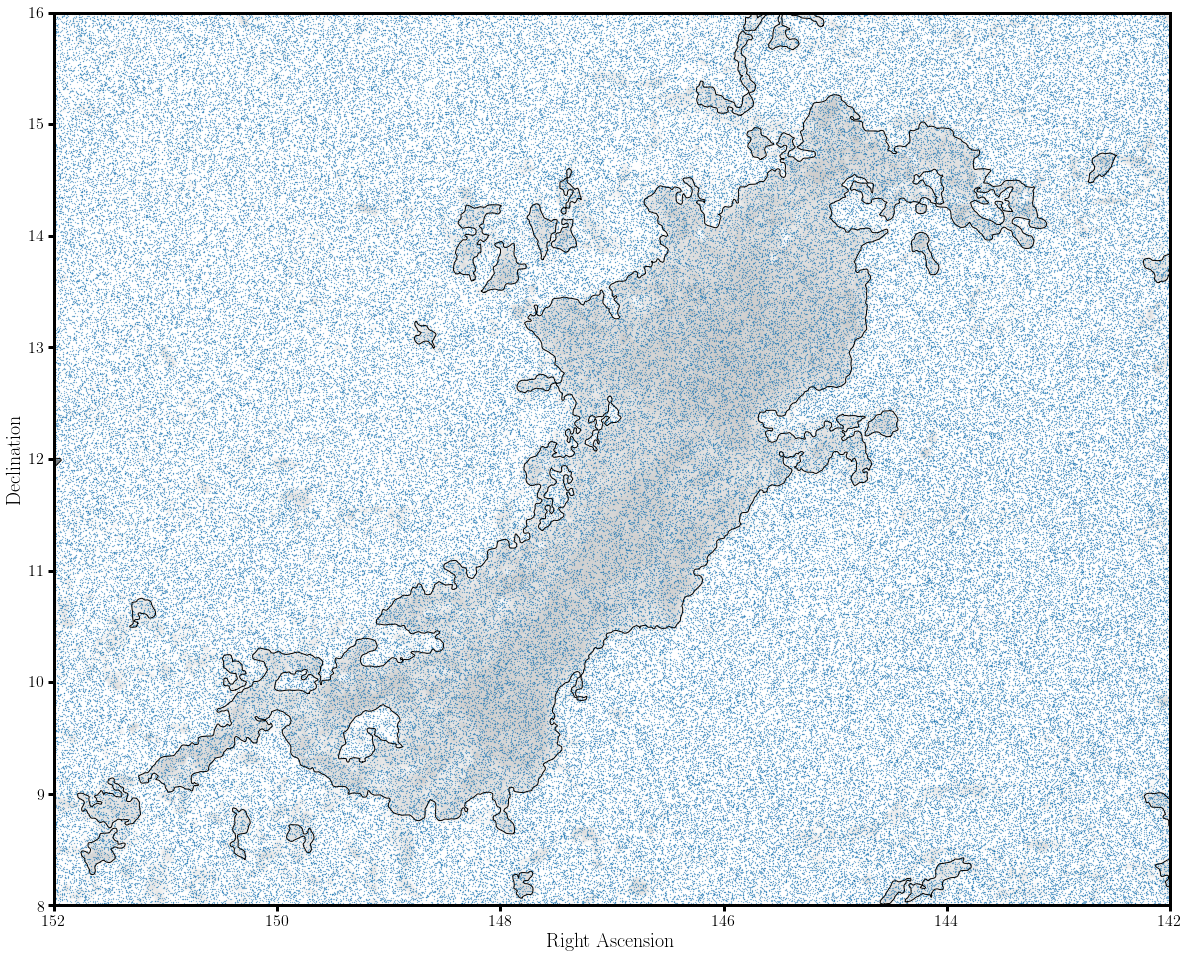

In [147]:
# Plotting stuff:
# Plot grayscale image
# Overlay contours
# Plot Gaia sources in footprint

import matplotlib.pyplot as plt
plt.style.use('sm')
% matplotlib inline
from seaborn import xkcd_palette
blue=xkcd_palette(['windows blue'])[0]

fig=plt.figure(1,figsize=(20,20))
subplt=plt.subplot(111)

# Show grayscale map
plt.imshow(img, zorder=-1, extent=[157, 141, 2, 18],alpha=0.5,cmap=plt.get_cmap('gray'))

# Overlay selected contours
for n, contour in enumerate(filtered_contours):
    xs=contour[:, 1]*(-16./float(imgx))+157
    ys=contour[:, 0]*(-16./float(imgy))+18
    subplt.plot(xs, ys, linewidth=1, color='k', alpha=1.0)

# Check image pixel value at each source's location,
# if it meets same threshold as the contouring, plot
#for row in results.itertuples():
#    if img[row.y][row.x]<contour_thres:
#        subplt.plot(row.ra,row.dec,marker='o',color=blue,markersize=3*(np.sqrt(row.parallax)-2))
 
subplt.scatter(results['ra'],results['dec'],s=0.05)
subplt.set_xlim(152,142)
subplt.set_ylim(8,16)
subplt.set_xlabel('Right Ascension',fontsize=20)
subplt.set_ylabel('Declination',fontsize=20)